In [5]:
import os

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras as k
from keras.models import Sequential
from keras.layers import Conv2D,BatchNormalization,Activation,GlobalAveragePooling2D,Dropout,Dense,MaxPooling2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,precision_score,recall_score,f1_score

In [17]:
train=r'D:\plant disease\dataset\Train\Train'
test=r'D:\plant disease\dataset\Test\Test'
val=r'D:\plant disease\dataset\Validation\Validation'

In [18]:
#Data Augmentation
img_size=(224,224)
batch_size=32

# Scaling of Pixel Values for Training data
# Little Augmentation of the Training data for better results :)
trdata=ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

# Scaling of pixel values for Testing and Validation sets
tegen=ImageDataGenerator(rescale=1.0/255)
valgen=ImageDataGenerator(rescale=1.0/255)

In [19]:
traing=trdata.flow_from_directory(
    train,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)
testg = tegen.flow_from_directory(
    test,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb', 
    class_mode='categorical',
    shuffle=False
)
valg = valgen.flow_from_directory(
    val,
    target_size=img_size,
    batch_size=batch_size,
    color_mode='rgb',  
    class_mode='categorical',
    shuffle=True,
)

Found 1322 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


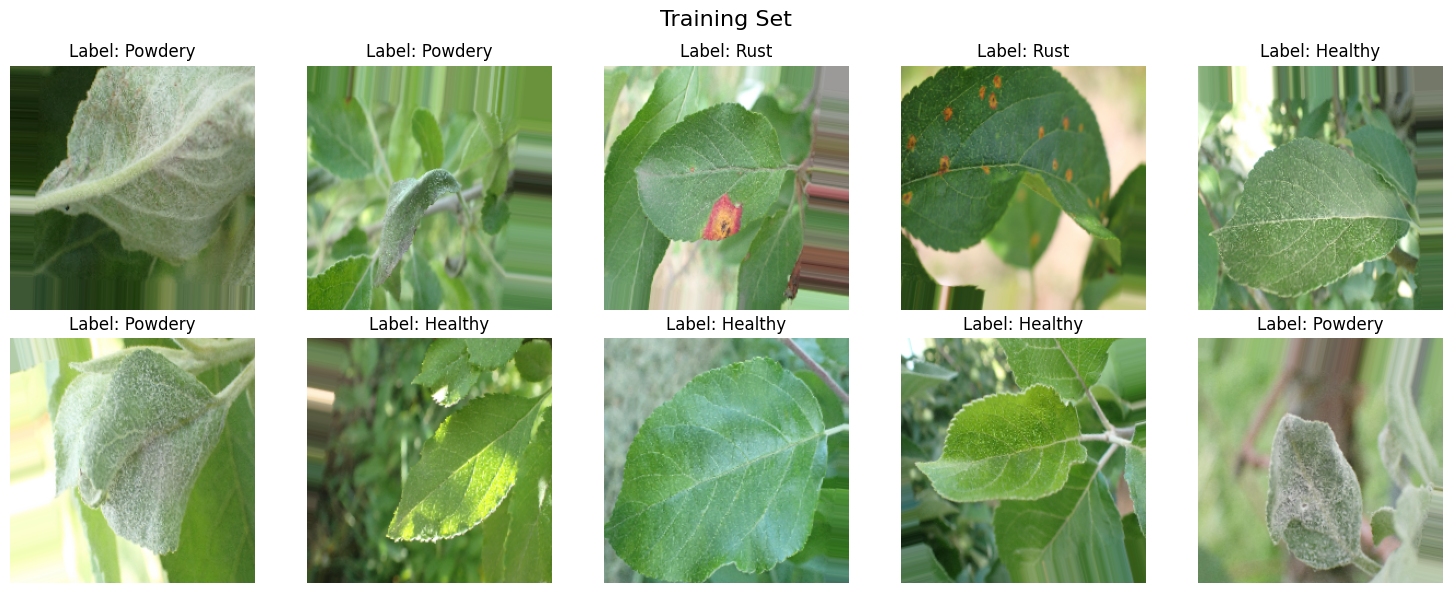

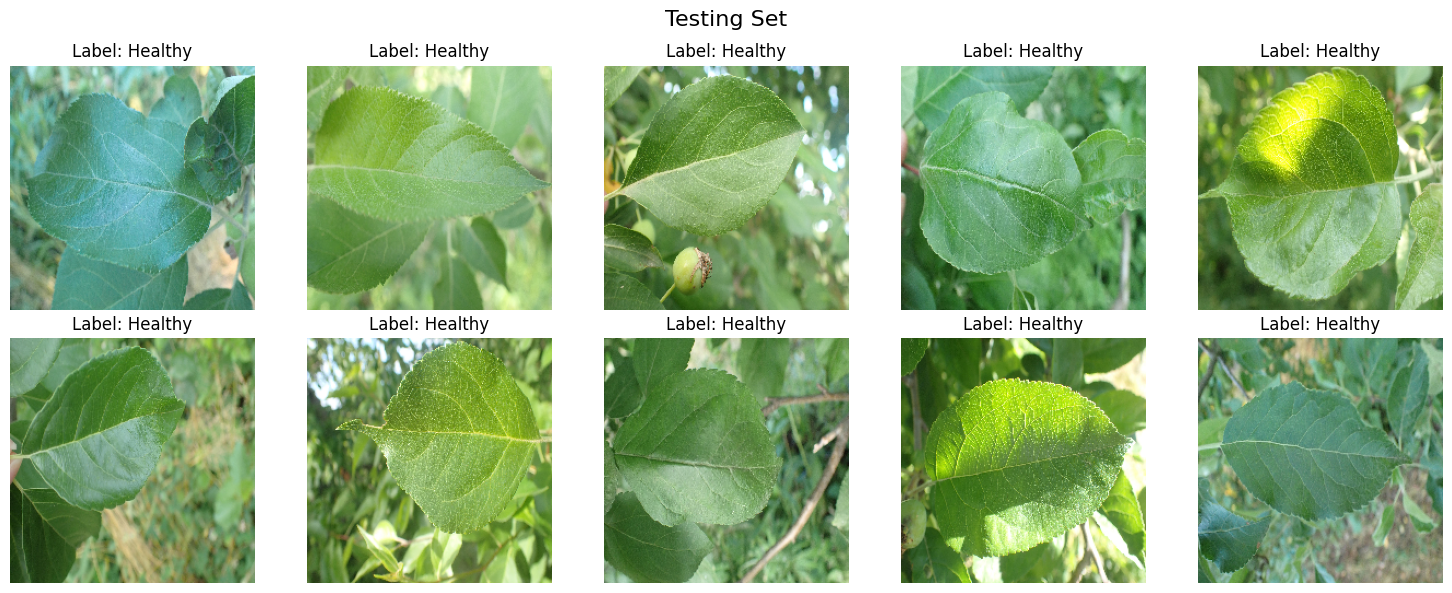

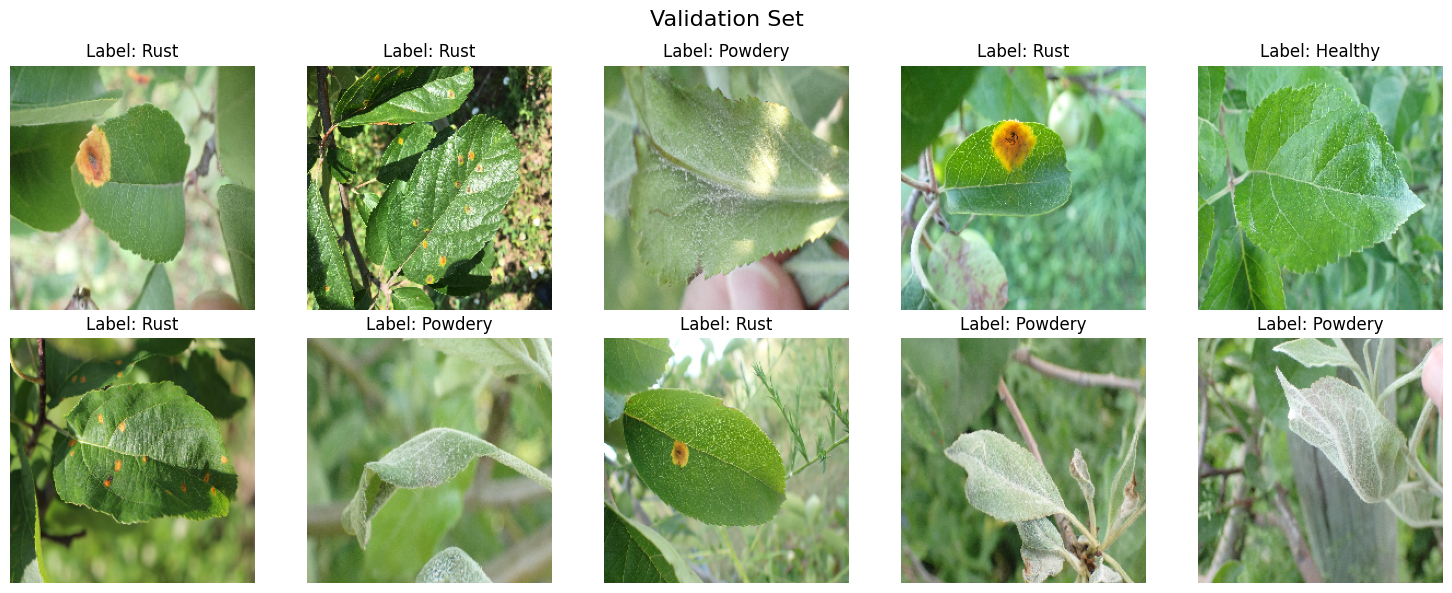

In [20]:
# Displaying the training and testing datsets
# Only 10 Images from each set

def plot_images_from_generator(generator, title, num_images=10, images_per_row=5):
    images, labels = next(generator)
    images = images[:num_images]
    labels = labels[:num_images]
    num_rows = (num_images + images_per_row - 1) // images_per_row
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 3 * num_rows))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for i in range(num_images):
        img = images[i]
        label = labels[i]
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Label: {list(generator.class_indices.keys())[label.argmax()]}")
    
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_images_from_generator(traing, "Training Set", num_images=10, images_per_row=5)
plot_images_from_generator(testg, "Testing Set", num_images=10, images_per_row=5)
plot_images_from_generator(valg, "Validation Set", num_images=10, images_per_row=5)

In [21]:
model = Sequential()

# CNN Layer 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(224, 224, 3)))  
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 2
model.add(Conv2D(64, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#CNN Layer 3
model.add(Conv2D(256, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

#Global Average Pooling layer is used instead of Flatten as it is more effiecient
#Note: There is feature loss when we use GAP
model.add(GlobalAveragePooling2D())

#Dense Layer 1
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 2
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer 3
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Output Layer
model.add(Dense(3, activation='softmax'))

#Adam Optimizer
opt = k.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

c:\Users\Student\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,115,203 (4.25 MB)

 Trainable params: 1,110,851 (4.24 MB)

 Non-trainable params: 4,352 (17.00 KB)

In [22]:
# I will be using EarlyStopping and Reduce Learining Rate
es=EarlyStopping(monitor='val_loss', patience=25, verbose=1, restore_best_weights=True)
lr=ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=10, verbose=1, min_delta=0.0001)

callbacks_list=[es,lr]

In [23]:
batch_x, batch_y = next(traing)
print(f"Image batch shape: {batch_x.shape}")  # Should be (batch_size, img_size[0], img_size[1], 3)
print(f"Label batch shape: {batch_y.shape}")  # Should be (batch_size, NUM_CLASSES)


Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 3)


In [24]:
# Fit the model :)
history = model.fit(
    traing,
    epochs=30,
    validation_data=valg,
    callbacks=callbacks_list
)

c:\Users\Student\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.4971 - loss: 1.5120 - val_accuracy: 0.3333 - val_loss: 1.1124 - learning_rate: 0.0010
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.6644 - loss: 1.0431 - val_accuracy: 0.3333 - val_loss: 1.6719 - learning_rate: 0.0010
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7196 - loss: 0.7812 - val_accuracy: 0.3333 - val_loss: 1.7680 - learning_rate: 0.0010
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.7607 - loss: 0.6884 - val_accuracy: 0.3333 - val_loss: 2.2485 - learning_rate: 0.0010
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7891 - loss: 0.5588 - val_accuracy: 0.4000 - val_loss: 2.0968 - learning_rate: 0.0010
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.8287 - loss: 0.5035 - val_accuracy: 0.3333 - val_loss: 2.9033 - learning_rate: 0.0010
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8464 - loss: 0.4712 - val_accuracy: 

In [25]:
# Predicting
y_pred = np.argmax(model.predict(testg), axis=1)
y_true = testg.classes

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


Accuracy:  0.8466666666666667
Recall:  0.8466666666666667
Precision:  0.8616502216502216
F1 Score:  0.8444892008273149
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.92      0.92        50
           2       0.92      0.68      0.78        50

    accuracy                           0.85       150
   macro avg       0.86      0.85      0.84       150
weighted avg       0.86      0.85      0.84       150



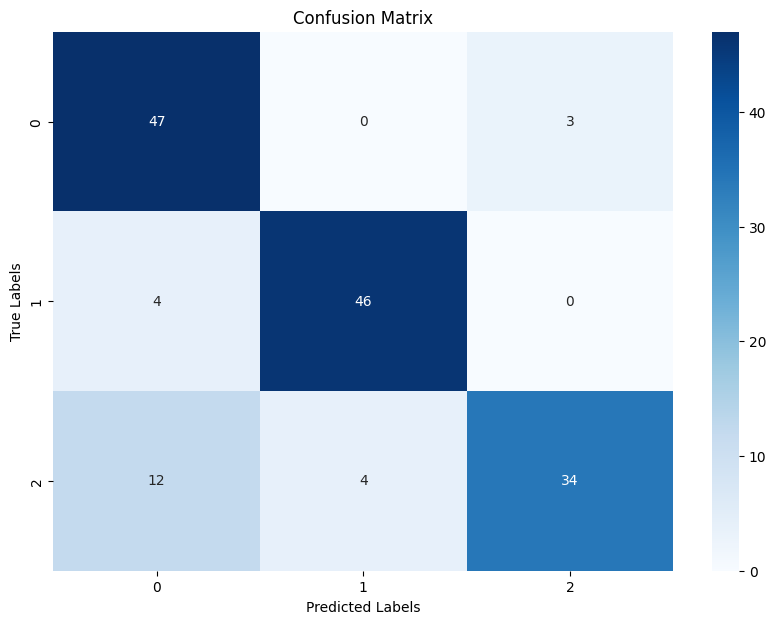

Training class indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}
Test class indices: {'Healthy': 0, 'Powdery': 1, 'Rust': 2}


In [26]:
#Evaluation Metrics
print('Accuracy: ',accuracy_score(y_true, y_pred))
print('Recall: ',recall_score(y_true, y_pred,average='weighted'))
print('Precision: ',precision_score(y_true, y_pred,average='weighted'))
print('F1 Score: ',f1_score(y_true, y_pred,average='weighted'))

# Print Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            )
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print Training and Test Class Indices
print("Training class indices:", traing.class_indices)
print("Test class indices:", testg.class_indices)